In [99]:
import cv2
import matplotlib.pyplot as plt
import os
import shutil
import json
from collections import Counter
import numpy as np
import os
import shutil
import json
import random

In [100]:
import os
from collections import defaultdict

In [101]:
def check_img_annot(path_img, path_txt):
    frame = cv2.imread(path_img).copy()
    box = []
    with open(path_txt, "r") as f:
        for i in f:
            box.append(i.split())
    #print("box : class, x, y, w, h \n", box)
    f.close()

    for boxx in box:
        
        cl,x,y,w,h = [eval(i) for i in boxx]

        h_frame,w_frame,channel = frame.shape

        # top left
        xtl = int(x*w_frame-w*w_frame/2)
        ytl = int(y*h_frame+h*h_frame/2)

        # bottom right
        xbr = int(x*w_frame+w*w_frame/2)
        ybr = int(y*h_frame-h*h_frame/2)

        frame = cv2.rectangle(frame, (xtl,ytl),(xbr,ybr),(0,255,0),2 )

    plt.imshow(frame)
    plt.show()

In [102]:
def coco_to_yolo(coco_bbox, image_width, image_height):
    x_min, y_min, width, height = coco_bbox
    
    # COCO format to YOLO format
    center_x = (x_min + width / 2) / image_width
    center_y = (y_min + height / 2) / image_height
    yolo_width = width / image_width
    yolo_height = height / image_height
    
    return [center_x, center_y, yolo_width, yolo_height]

def yolo_to_coco(yolo_bbox, image_width, image_height):
    center_x, center_y, yolo_width, yolo_height = yolo_bbox
    
    # YOLO format to COCO format
    x_min = int((center_x - yolo_width / 2) * image_width)
    y_min = int((center_y - yolo_height / 2) * image_height)
    width = int(yolo_width * image_width)
    height = int(yolo_height * image_height)
    
    return [x_min, y_min, width, height]

In [103]:
data = json.load(open('../data/video1.json'))

In [104]:
def get_data(video_path, annotation_path, data_save_path, per=1, 
             per_train=80, per_val=10):
    info = {}

    # IMAGES WITH ANNOTATION
    data = json.load(open(annotation_path))
    set_img = {i["image_id"] for i in data["annotations"]}

    # REDIMENTION OF IMG
    cap = cv2.VideoCapture(video_path)
    _,frame = cap.read()
    Ho,Wo,_=frame.shape
    r = frame.shape[0]/frame.shape[1] # H/W
    new_W = frame.shape[1]/per
    new_H = r*new_W
    dim = (int(new_W), int(new_H))
    
    
    try:
        os.mkdir(os.path.join(data_save_path,"images"))
    except:
        print("directory 'images' was created")
        print("all new file will be add")
    
    # SAVE IMAGES WITH ANNOTATIONS IN "images"
    count = 1
    cap = cv2.VideoCapture(video_path)
    success, frame = cap.read()
    name_video = video_path.split("/")[-1].split(".")[0]
    
    while success:
        name = os.path.join(data_save_path,"images",
                            name_video+"_frame_"+str(count)+".png")
        if count in set_img:
            resized = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
            cv2.imwrite(name,resized)  # SAVE IMG
        success, frame = cap.read()
        count = count + 1
    cap.release()
    
    # SAVE ANNOTATION .TXT IN "labels"
    try:
        os.mkdir(os.path.join(data_save_path, "labels"))
    except:
        print("directory 'labels' was created")
        print("all news files will be add")
            
    for i in data["annotations"]:
        f = open(os.path.join(data_save_path,"labels",
                              name_video+"_frame_"+str(i["image_id"])+".txt"),"a")
        f.write(str(int(i["category_id"]-1))+ " ")
    
        # cl,x,y,w,h = [eval(i) for i in boxx] YOLO
        # # Bboxes are in [top-left-x, top-left-y, width, height]  COCO
        box = coco_to_yolo(i["bbox"], new_W, new_H)

        # due of resized
        box[0] = box[0]*new_W/Wo
        box[1] = box[1]*new_H/Ho
        box[2] = box[2]*new_W/Wo
        box[3] = box[3]*new_H/Ho
        
        for b in box:
            f.write( f"{b:.5f}" + " ")
        f.write("\n")
        f.close()
    
    # CREATE VAL, TEST, TRAIN
    '''
    labels = os.listdir(os.path.join(data_save_path,"labels"))
    train_labels = labels[0:int((len(labels) * per_train)/100)]
    val_labels = labels[int((len(labels) * per_train)/100):int((len(labels) * (per_train+per_val))/100)]
    test_labels = labels[int(len(labels) * (per_val+per_train)/100):]
    
    print("Directories to train")
    print("total : ", len(labels))
    print("train : ", len(train_labels))
    print("test  : ", len(test_labels))
    print("val   : ", len(val_labels))

    # copy images to train, val and test folders
    try:
        os.mkdir(os.path.join(data_save_path,"Train"))
    except:
        print("directory 'Train' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","images"))
    except:
        print("directory 'Train/images' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Train","labels"))
    except:
        print("directory was created")
        print("all new file will be add")

    for label in train_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+"/images/"+filename+'.png'
        img_dst = data_save_path+'/Train/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Train/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Val"))
    except:
        print("directory 'Val' was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","images"))
    except:
        print("directory 'Val/images' created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Val","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in val_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Val/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Val/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)

    try:
        os.mkdir(os.path.join(data_save_path,"Test"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","images"))
    except:
        print("directory was created")
        print("all new file will be add")
    try:
        os.mkdir(os.path.join(data_save_path,"Test","labels"))
    except:
        print("directory was created")
        print("all new file will be add")


    for label in test_labels:
        filename = label.split(".")[0]
        #path = os.getcwd()
        # images source and destination path
        img_src = data_save_path+'/images/'+filename+'.png'
        img_dst = data_save_path+'/Test/images/'+filename+'.png'
        # labels source and destination path
        label_src = data_save_path+'/labels/'+filename+'.txt'
        label_dst = data_save_path+'/Test/labels/'+filename+'.txt'
        
        shutil.copy(img_src, img_dst)
        shutil.copy(label_src, label_dst)
'''

    info["categories"] = data["categories"]
    return info


## Create data

In [144]:
get_data(video_path="../data/videos/video1.mp4", 
         annotation_path="../data/video1.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add
directory 'labels' was created
all news files will be add


{'categories': [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
  {'id': 2, 'name': '13_Bus', 'supercategory': ''},
  {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
  {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
  {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
  {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
  {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
  {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
  {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
  {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
  {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
  {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
  {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
  {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
  {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
  {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
  {'id': 17, 'name': 

In [145]:
get_data(video_path="../data/videos/video2.mp4", 
         annotation_path="../data/video2.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add
directory 'labels' was created
all news files will be add


{'categories': [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
  {'id': 2, 'name': '13_Bus', 'supercategory': ''},
  {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
  {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
  {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
  {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
  {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
  {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
  {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
  {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
  {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
  {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
  {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
  {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
  {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
  {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
  {'id': 17, 'name': 

In [146]:
get_data(video_path="../data/videos/video3.mp4", 
         annotation_path="../data/video3.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add
directory 'labels' was created
all news files will be add


{'categories': [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
  {'id': 2, 'name': '13_Bus', 'supercategory': ''},
  {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
  {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
  {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
  {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
  {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
  {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
  {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
  {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
  {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
  {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
  {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
  {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
  {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
  {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
  {'id': 17, 'name': 

In [147]:
get_data(video_path="../data/videos/video4.mp4", 
         annotation_path="../data/video4.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add
directory 'labels' was created
all news files will be add


{'categories': [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
  {'id': 2, 'name': '13_Bus', 'supercategory': ''},
  {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
  {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
  {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
  {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
  {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
  {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
  {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
  {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
  {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
  {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
  {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
  {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
  {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
  {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
  {'id': 17, 'name': 

In [148]:
get_data(video_path="../data/videos/video5.mp4", 
         annotation_path="../data/video5.json",
         data_save_path="../data/raster", per=1)

directory 'images' was created
all new file will be add
directory 'labels' was created
all news files will be add


{'categories': [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
  {'id': 2, 'name': '13_Bus', 'supercategory': ''},
  {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
  {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
  {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
  {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
  {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
  {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
  {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
  {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
  {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
  {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
  {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
  {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
  {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
  {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
  {'id': 17, 'name': 

In [168]:
categories = [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
              {'id': 2, 'name': '13_Bus', 'supercategory': ''},
              {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
              {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
              {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
              {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
              {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
              {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
              {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
              {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
              {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
              {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
              {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
              {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
              {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
              {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
              {'id': 17, 'name': '17_TC SemiTrailler Trailer', 'supercategory': ''},
              {'id': 18, 'name': '18_Triciclo', 'supercategory': ''},
              {'id': 19, 'name': '19_Ambulancia', 'supercategory': ''}]

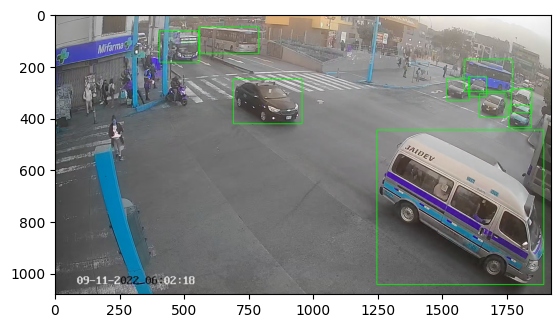

In [149]:
check_img_annot(path_img="../data/raster/images/video1_frame_17446.png",
                path_txt="../data/raster/labels/video1_frame_17446.txt")

In [151]:
txt_dir = '../data/raster/labels'

In [152]:
#image_to_classes
class_to_images = defaultdict(list)
image_to_classes = {}
for txt_file in os.listdir(txt_dir):
        if txt_file.endswith('.txt'):
            image_name = txt_file.replace('.txt', '.png')  # Assuming images are in .jpg format
            with open(os.path.join(txt_dir, txt_file), 'r') as file:
                classes_in_image = set()
                for line in file:
                    class_label = line.split()[0]  # Assuming class label is the first entry in each row
                    class_to_images[class_label].append(image_name)
                    classes_in_image.add(class_label)
                image_to_classes[image_name] = list(classes_in_image)

In [153]:
# Step 1: Count the occurrences of each class across all images
class_counts = Counter()
for classes in image_to_classes.values():
    class_counts.update(classes)
# Step 2: Define a proportional split (e.g., 80% train, 20% test)
test_size = 0.2
train_set = {}
test_set = {}
current_test_counts = Counter()
# Step 3: Split the data while maintaining proportionality
for image, classes in image_to_classes.items():
    if all(current_test_counts[cls] / class_counts[cls] <= test_size for cls in classes):
        test_set[image] = classes
        current_test_counts.update(classes)
    else:
        train_set[image] = classes

In [154]:
# Print the result
print(f"Train set: {len(train_set)} images")
print(f"Test set: {len(test_set)} images")

Train set: 3891 images
Test set: 971 images


In [155]:

# Optional: Verify class distribution in the test set
test_class_distribution = Counter()
for classes in test_set.values():
    test_class_distribution.update(classes)

    # Optional: Verify class distribution in the test set
train_class_distribution = Counter()
for classes in train_set.values():
    train_class_distribution.update(classes)

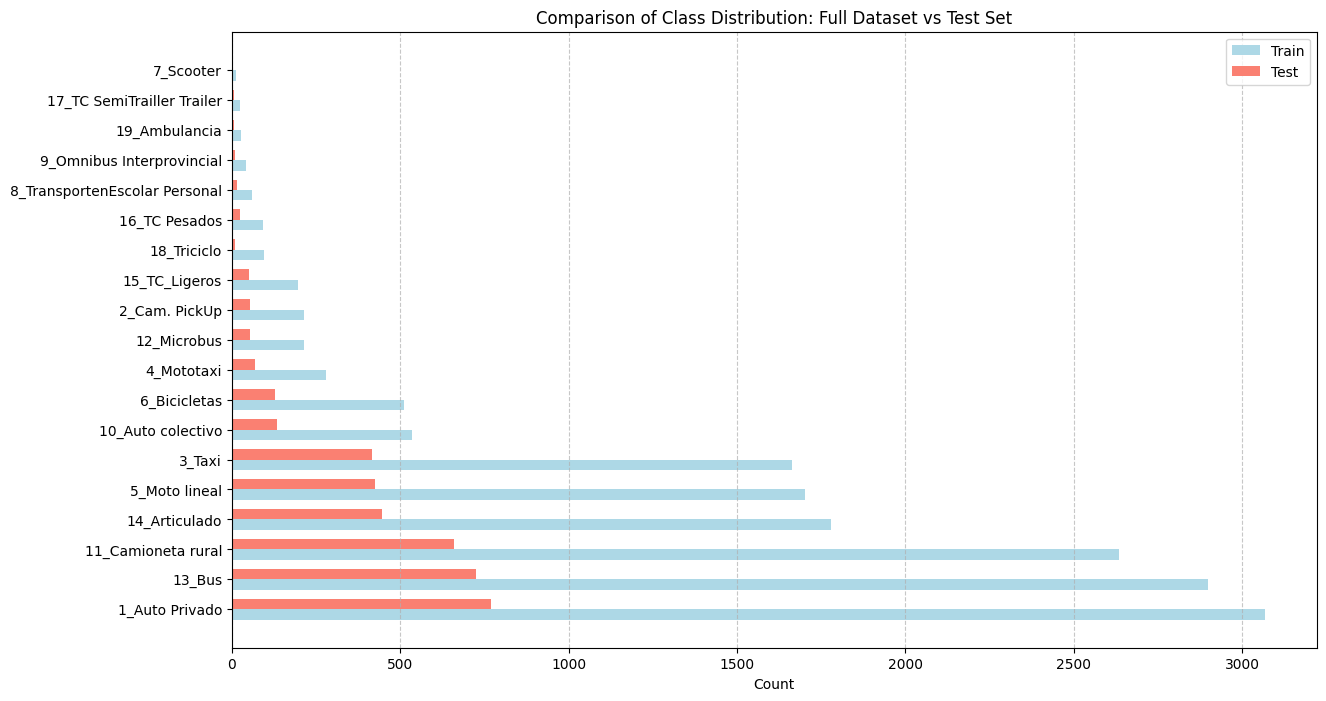

In [169]:
categories = [{'id': 1, 'name': '1_Auto Privado', 'supercategory': ''},
              {'id': 2, 'name': '13_Bus', 'supercategory': ''},
              {'id': 3, 'name': '11_Camioneta rural', 'supercategory': ''},
              {'id': 4, 'name': '12_Microbus', 'supercategory': ''},
              {'id': 5, 'name': '4_Mototaxi', 'supercategory': ''},
              {'id': 6, 'name': '5_Moto lineal', 'supercategory': ''},
              {'id': 7, 'name': '9_Omnibus Interprovincial', 'supercategory': ''},
              {'id': 8, 'name': '10_Auto colectivo', 'supercategory': ''},
              {'id': 9, 'name': '14_Articulado', 'supercategory': ''},
              {'id': 10, 'name': '2_Cam. PickUp', 'supercategory': ''},
              {'id': 11, 'name': '3_Taxi', 'supercategory': ''},
              {'id': 12, 'name': '6_Bicicletas', 'supercategory': ''},
              {'id': 13, 'name': '7_Scooter', 'supercategory': ''},
              {'id': 14, 'name': '8_TransportenEscolar Personal', 'supercategory': ''},
              {'id': 15, 'name': '15_TC_Ligeros', 'supercategory': ''},
              {'id': 16, 'name': '16_TC Pesados', 'supercategory': ''},
              {'id': 17, 'name': '17_TC SemiTrailler Trailer', 'supercategory': ''},
              {'id': 18, 'name': '18_Triciclo', 'supercategory': ''},
              {'id': 19, 'name': '19_Ambulancia', 'supercategory': ''}]
# # Create a mapping from ID to name
id_to_name = {str(category['id'] - 1): category['name'] for category in categories}

# Replace numeric keys with category names
mapped_test_distribution = {id_to_name[k]: v for k, v in test_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_test_distribution = dict(sorted(mapped_test_distribution.items(), key=lambda item: item[1], reverse=True))

# Replace numeric keys with category names
mapped_train_distribution = {id_to_name[k]: v for k, v in train_class_distribution.items() if k in id_to_name}

# Sort the mapped data by values in descending order
sorted_mapped_train_distribution = dict(sorted(mapped_train_distribution.items(), key=lambda item: item[1], reverse=True))

# Ensure both dictionaries have the same keys in the same order
categories = list(sorted_mapped_train_distribution.keys())

test_values = [sorted_mapped_test_distribution.get(cat, 0) for cat in categories]
full_values = [sorted_mapped_train_distribution[cat] for cat in categories]

# Set up the plot
x = np.arange(len(categories))
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

bars1 = ax.barh(x - width/2, full_values, width, label='Train', color='lightblue')
bars2 = ax.barh(x + width/2, test_values, width, label='Test', color='salmon')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Count')
ax.set_title('Comparison of Class Distribution: Full Dataset vs Test Set')
ax.set_yticks(x)
ax.set_yticklabels(categories)
ax.legend()

# Add a grid for easier reading
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [162]:
import shutil

In [173]:

for i in train_set.keys():
    shutil.copy('../data/raster/images/'+i,'../data/raster/Train/images/'+i)
    shutil.copy('../data/raster/labels/'+i.split('.')[0]+'.txt', '../data/raster/Train/labels/'+i.split('.')[0]+'.txt')


for i in test_set.keys():
    shutil.copy('../data/raster/images/'+i,'../data/raster/Test/images/'+i)
    shutil.copy('../data/raster/labels/'+i.split('.')[0]+'.txt', '../data/raster/Test/labels/'+i.split('.')[0]+'.txt')
